# Movie Recommender System - Data Exploration (FIXED)

Phase 1: Complete analysis with error handling

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from pathlib import Path
import sys

# Set style
plt.style.use('default')
sns.set_palette('husl')

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Movie Recommender - Phase 1 Data Exploration (FIXED)")
print("====================================================")

Movie Recommender - Phase 1 Data Exploration (FIXED)


## 1. Load Data from Database

In [46]:
# Connect to database
db_path = "../data/movielens.db"
conn = sqlite3.connect(db_path)

# Load data - using all available data for analysis
ratings = pd.read_sql_query("SELECT * FROM ratings", conn)
movies = pd.read_sql_query("SELECT * FROM movies", conn)

print(f"Ratings shape: {ratings.shape}")
print(f"Movies shape: {movies.shape}")
print(f"Database connection successful!")

# Display first few rows
print("\nRatings sample:")
print(ratings.head())

print("\nMovies sample:")
print(movies.head())

Ratings shape: (50000, 4)
Movies shape: (6730, 3)
Database connection successful!

Ratings sample:
   userId  movieId  rating   timestamp
0  122270     8360     3.5  1335056824
1   49018       32     2.0  1000194636
2   89527   109374     3.5  1420536400
3  106704     1060     3.0   948576477
4   47791     1732     2.0  1137685703

Movies sample:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


## 2. Basic Statistics & Data Quality

In [47]:
# Basic statistics
print("=== DATASET OVERVIEW ===")
print(f"Total ratings: {len(ratings):,}")
print(f"Unique users: {ratings['userId'].nunique():,}")
print(f"Unique movies rated: {ratings['movieId'].nunique():,}")
print(f"Total movies in catalog: {len(movies):,}")
print(f"Average rating: {ratings['rating'].mean():.2f}")
print(f"Rating std: {ratings['rating'].std():.2f}")

# Sparsity calculation
total_possible = ratings['userId'].nunique() * ratings['movieId'].nunique()
actual_ratings = len(ratings)
sparsity = (1 - actual_ratings / total_possible) * 100
print(f"Matrix sparsity: {sparsity:.2f}%")
print(f"Matrix density: {100-sparsity:.4f}%")

# Data quality checks
print("\n=== DATA QUALITY ===")
print(f"Missing values in ratings: {ratings.isnull().sum().sum()}")
print(f"Missing values in movies: {movies.isnull().sum().sum()}")
print(f"Duplicate user-movie pairs: {ratings[['userId', 'movieId']].duplicated().sum()}")
print(f"Invalid ratings: {len(ratings[(ratings['rating'] < 0.5) | (ratings['rating'] > 5.0)])}")

=== DATASET OVERVIEW ===
Total ratings: 50,000
Unique users: 33,226
Unique movies rated: 6,730
Total movies in catalog: 6,730
Average rating: 3.52
Rating std: 1.05
Matrix sparsity: 99.98%
Matrix density: 0.0224%

=== DATA QUALITY ===
Missing values in ratings: 0
Missing values in movies: 0
Duplicate user-movie pairs: 0
Invalid ratings: 0


## 3. Cold Start Problem Analysis

=== COLD START PROBLEM ANALYSIS ===
Users with <5 ratings (cold start): 32,423 (97.6%)
Movies with <5 ratings (cold start): 4,475 (66.5%)


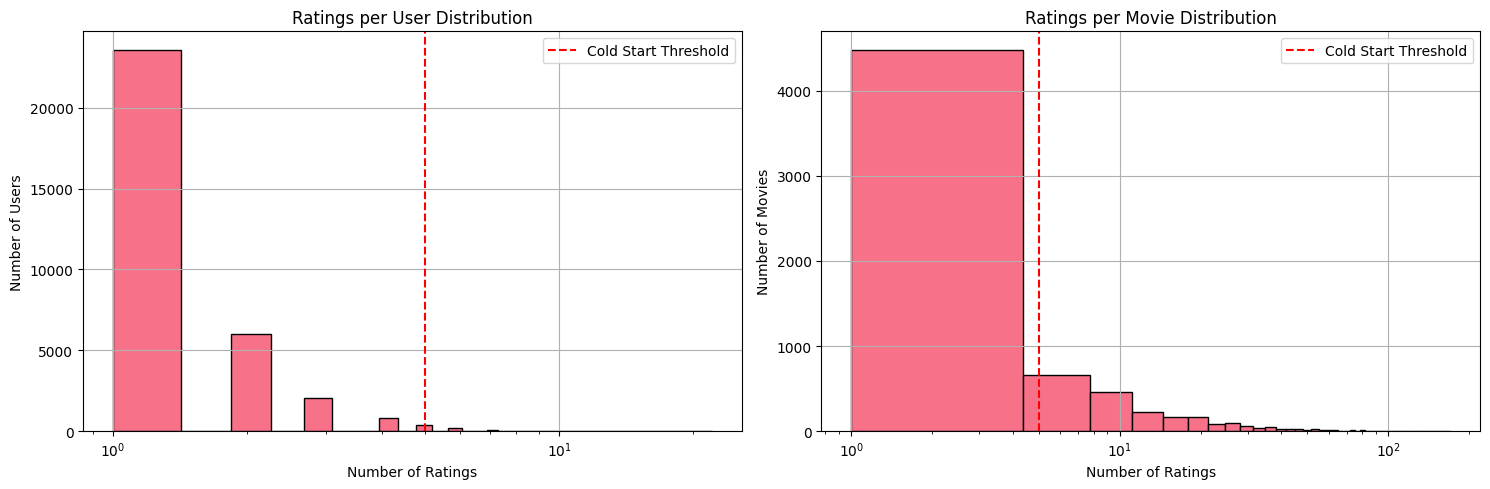


Cold Start Impact:
- Our recommender needs fallback strategies for 32,423 users
- Popular movie recommendations help with 4,475 rarely-rated movies


In [48]:
# Analyze cold start problem - IMPORTANT FOR PHASE 1
print("=== COLD START PROBLEM ANALYSIS ===")

user_counts = ratings.groupby('userId').size()
movie_counts = ratings.groupby('movieId').size()

# Cold start users (few ratings)
cold_start_users = user_counts[user_counts < 5]
print(f"Users with <5 ratings (cold start): {len(cold_start_users):,} ({len(cold_start_users)/len(user_counts)*100:.1f}%)")

# Cold start movies
cold_start_movies = movie_counts[movie_counts < 5]
print(f"Movies with <5 ratings (cold start): {len(cold_start_movies):,} ({len(cold_start_movies)/len(movie_counts)*100:.1f}%)")

# Visualize cold start distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# User rating distribution
user_counts.hist(bins=50, ax=axes[0], edgecolor='black')
axes[0].axvline(x=5, color='red', linestyle='--', label='Cold Start Threshold')
axes[0].set_title('Ratings per User Distribution')
axes[0].set_xlabel('Number of Ratings')
axes[0].set_ylabel('Number of Users')
axes[0].set_xscale('log')
axes[0].legend()

# Movie rating distribution
movie_counts.hist(bins=50, ax=axes[1], edgecolor='black')
axes[1].axvline(x=5, color='red', linestyle='--', label='Cold Start Threshold')
axes[1].set_title('Ratings per Movie Distribution')
axes[1].set_xlabel('Number of Ratings')
axes[1].set_ylabel('Number of Movies')
axes[1].set_xscale('log')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nCold Start Impact:")
print(f"- Our recommender needs fallback strategies for {len(cold_start_users):,} users")
print(f"- Popular movie recommendations help with {len(cold_start_movies):,} rarely-rated movies")

## 4. Rating Distribution Analysis

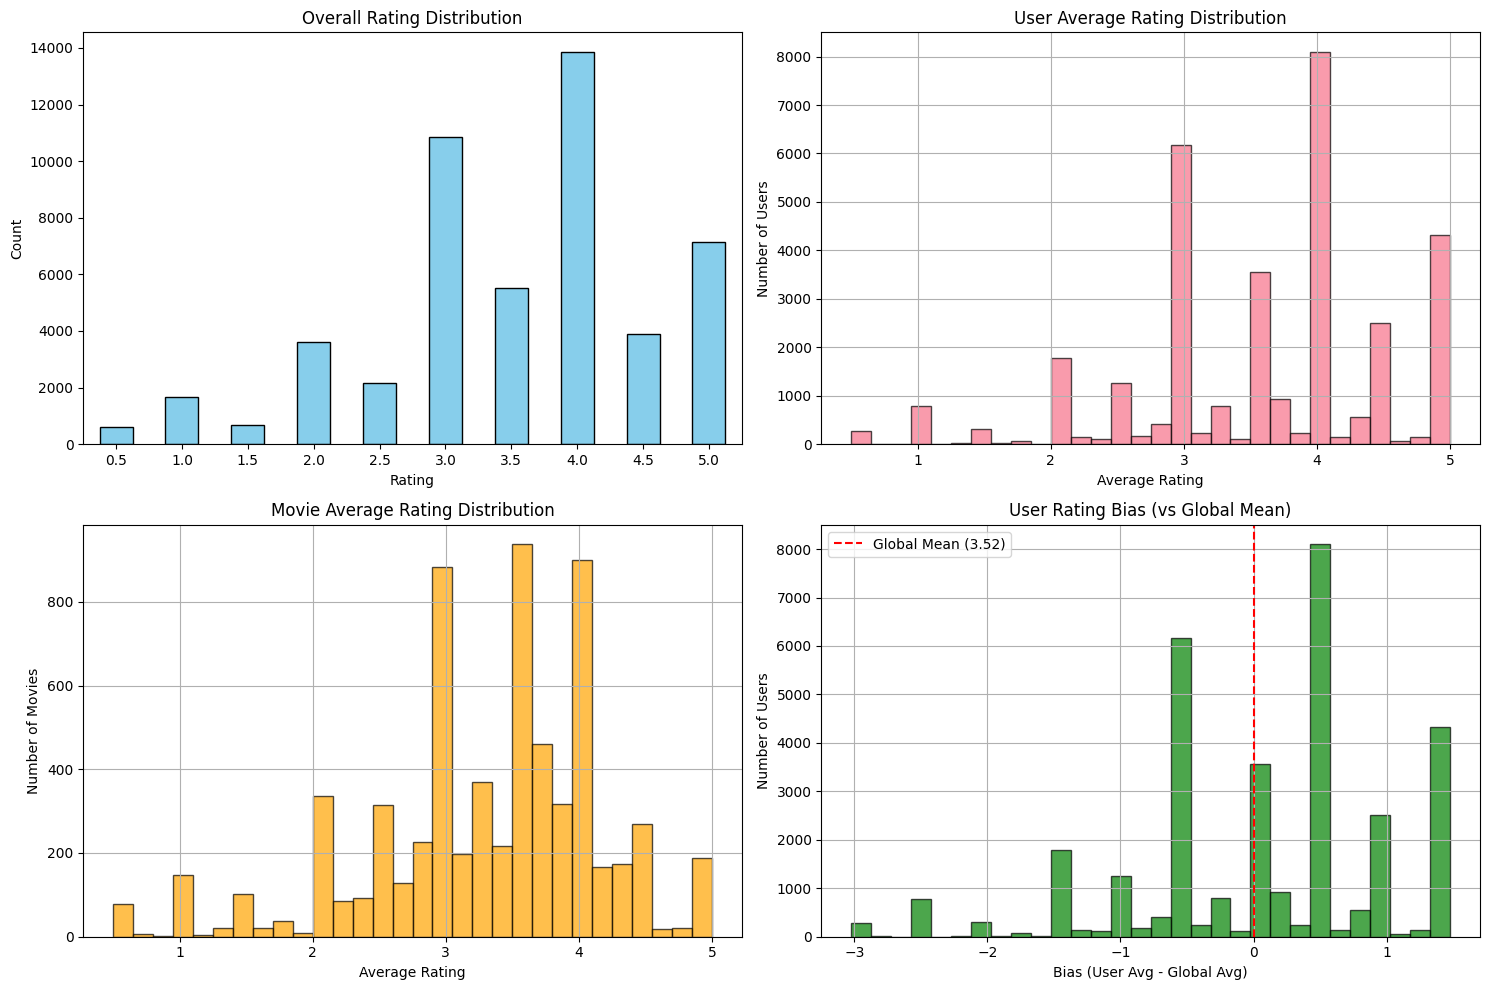

Rating insights:
- Most common rating: 4.0 (13,858 occurrences)
- Users tend to rate 3.57 on average
- Movies average 3.29 rating


In [49]:
# Rating distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall rating distribution
rating_counts = ratings['rating'].value_counts().sort_index()
rating_counts.plot(kind='bar', ax=axes[0,0], color='skyblue', edgecolor='black')
axes[0,0].set_title('Overall Rating Distribution')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=0)

# User average ratings
user_avg_ratings = ratings.groupby('userId')['rating'].mean()
user_avg_ratings.hist(bins=30, ax=axes[0,1], edgecolor='black', alpha=0.7)
axes[0,1].set_title('User Average Rating Distribution')
axes[0,1].set_xlabel('Average Rating')
axes[0,1].set_ylabel('Number of Users')

# Movie average ratings
movie_avg_ratings = ratings.groupby('movieId')['rating'].mean()
movie_avg_ratings.hist(bins=30, ax=axes[1,0], edgecolor='black', alpha=0.7, color='orange')
axes[1,0].set_title('Movie Average Rating Distribution')
axes[1,0].set_xlabel('Average Rating')
axes[1,0].set_ylabel('Number of Movies')

# Rating bias analysis
global_mean = ratings['rating'].mean()
user_bias = user_avg_ratings - global_mean
user_bias.hist(bins=30, ax=axes[1,1], edgecolor='black', alpha=0.7, color='green')
axes[1,1].set_title('User Rating Bias (vs Global Mean)')
axes[1,1].set_xlabel('Bias (User Avg - Global Avg)')
axes[1,1].set_ylabel('Number of Users')
axes[1,1].axvline(x=0, color='red', linestyle='--', label=f'Global Mean ({global_mean:.2f})')
axes[1,1].legend()

plt.tight_layout()
plt.show()

print(f"Rating insights:")
print(f"- Most common rating: {rating_counts.idxmax()} ({rating_counts.max():,} occurrences)")
print(f"- Users tend to rate {user_avg_ratings.mean():.2f} on average")
print(f"- Movies average {movie_avg_ratings.mean():.2f} rating")

## 5. Movie Popularity Analysis (FIXED)

=== MOST POPULAR MOVIES ===
(by number of ratings)
 1. Star Wars: Episode IV - A New Hope (1977)          - 170 ratings (avg: 4.2)
 2. Pulp Fiction (1994)                                - 163 ratings (avg: 4.2)
 3. Forrest Gump (1994)                                - 154 ratings (avg: 3.9)
 4. Jurassic Park (1993)                               - 154 ratings (avg: 3.7)
 5. Shawshank Redemption, The (1994)                   - 146 ratings (avg: 4.4)
 6. Schindler's List (1993)                            - 145 ratings (avg: 4.4)
 7. Silence of the Lambs, The (1991)                   - 144 ratings (avg: 4.2)
 8. Terminator 2: Judgment Day (1991)                  - 143 ratings (avg: 3.9)
 9. Matrix, The (1999)                                 - 140 ratings (avg: 4.2)
10. Fugitive, The (1993)                               - 131 ratings (avg: 3.9)

=== HIGHEST RATED MOVIES ===
(minimum 100 ratings)
 1. Usual Suspects, The (1995)                         - 4.48 stars (111 ratings)
 2. Shawshank R

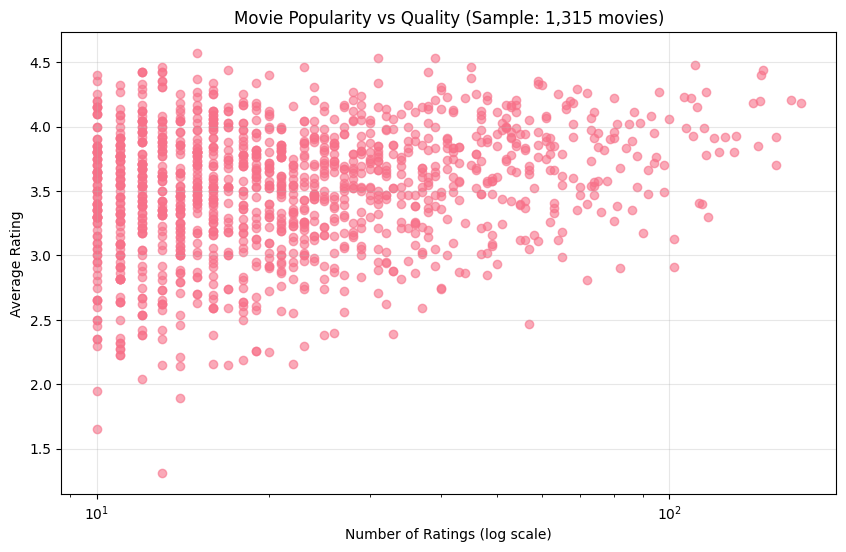


Sampled 1,315 movies for visualization


In [50]:
# Movie popularity analysis - FIXED SAMPLING
movie_stats = ratings.groupby('movieId').agg({
    'rating': ['count', 'mean', 'std']
}).round(2)

movie_stats.columns = ['num_ratings', 'avg_rating', 'rating_std']
movie_stats = movie_stats.reset_index()
movie_stats = movie_stats.merge(movies[['movieId', 'title', 'genres']], on='movieId')

print("=== MOST POPULAR MOVIES ===")
print("(by number of ratings)")
top_popular = movie_stats.nlargest(10, 'num_ratings')[['title', 'num_ratings', 'avg_rating']]
for i, (_, row) in enumerate(top_popular.iterrows(), 1):
    print(f"{i:2d}. {row['title'][:50]:50s} - {row['num_ratings']:,} ratings (avg: {row['avg_rating']:.1f})")

print("\n=== HIGHEST RATED MOVIES ===")
print("(minimum 100 ratings)")
top_rated = movie_stats[movie_stats['num_ratings'] >= 100].nlargest(10, 'avg_rating')[['title', 'num_ratings', 'avg_rating']]
for i, (_, row) in enumerate(top_rated.iterrows(), 1):
    print(f"{i:2d}. {row['title'][:50]:50s} - {row['avg_rating']:.2f} stars ({row['num_ratings']:,} ratings)")

# FIXED: Popularity vs Quality scatter plot
plt.figure(figsize=(10, 6))
# Only sample movies with at least 10 ratings to avoid sampling error
movies_with_ratings = movie_stats[movie_stats['num_ratings'] >= 10]
sample_size = min(5000, len(movies_with_ratings))  # FIXED: Check available size
sample_movies = movies_with_ratings.sample(n=sample_size, random_state=42)

plt.scatter(sample_movies['num_ratings'], sample_movies['avg_rating'], alpha=0.6)
plt.xscale('log')
plt.xlabel('Number of Ratings (log scale)')
plt.ylabel('Average Rating')
plt.title(f'Movie Popularity vs Quality (Sample: {sample_size:,} movies)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nSampled {sample_size:,} movies for visualization")

## 6. Test Our Trained Model (FIXED)

In [ ]:
# Test our trained recommendation model - FIXED WITH ERROR HANDLING
print("=== TESTING OUR TRAINED MODEL (FIXED) ===")

# Add path to import our model
sys.path.append('../src')

model_trained = False
recommender = None

try:
    # Im Notebook ganz oben:
    import sys, pathlib
    sys.path.insert(0, str((pathlib.Path.cwd().parent / "src").resolve()))
    # jetzt findet Python das Paket "models" unter src/models

    from models.predict_model import MovieRecommender
    
    # Check if model files exist first
    model_files = [
        '../models/svd_model.pkl',
        '../models/user_factors.pkl', 
        '../models/item_factors.pkl',
        '../models/user_item_matrix.pkl'
    ]
    
    missing_files = [f for f in model_files if not Path(f).exists()]
    
    if missing_files:
        print("❌ Model files missing:")
        for file in missing_files:
            print(f"   - {file}")
        print("\n🔧 TO FIX: Run this command first:")
        print("   python src/models/train_model.py")
    else:
        # Try to load the model
        recommender = MovieRecommender()
        
        if recommender.models_loaded:
            print("✅ Model loaded successfully!")
            model_trained = True
            
            # Test with several users
            sample_users = ratings['userId'].sample(3, random_state=42).tolist()
            
            for user_id in sample_users:
                print(f"\n--- Recommendations for User {user_id} ---")
                
                # Show user's existing ratings (sample)
                user_ratings = ratings[ratings['userId'] == user_id].merge(movies, on='movieId')
                if len(user_ratings) > 0:
                    user_ratings_sample = user_ratings.nlargest(3, 'rating')[['title', 'rating', 'genres']]
                    
                    print("User's top rated movies:")
                    for _, row in user_ratings_sample.iterrows():
                        print(f"  • {row['title'][:40]} - {row['rating']:.1f}★ ({row['genres']})")
                
                # Get recommendations
                recommendations = recommender.get_user_recommendations(user_id, 5)
                
                print("\nOur recommendations:")
                if isinstance(recommendations, list) and len(recommendations) > 0:
                    for i, rec in enumerate(recommendations, 1):
                        score = rec.get('predicted_rating', rec.get('avg_rating', 0))
                        title = rec.get('title', 'Unknown')[:40]
                        genres = rec.get('genres', 'Unknown')
                        print(f"  {i}. {title} - Predicted: {score:.2f}★ ({genres})")
                else:
                    print("  No recommendations available")
            
            # Test cold start scenario
            print(f"\n--- Cold Start Test (Unknown User 999999) ---")
            cold_recs = recommender.get_user_recommendations(999999, 5)
            print("Popular movie fallback:")
            if cold_recs:
                for i, rec in enumerate(cold_recs[:5], 1):
                    rating = rec.get('avg_rating', rec.get('predicted_rating', 0))
                    title = rec.get('title', 'Unknown')[:40]
                    genres = rec.get('genres', 'Unknown')
                    print(f"  {i}. {title} - {rating:.2f}★ ({genres})")
        else:
            print("❌ Model failed to load properly")
            
except ImportError as e:
    print(f"❌ Could not import model: {e}")
    print("\n🔧 TO FIX: Make sure your project structure is correct")
except Exception as e:
    print(f"❌ Error testing model: {e}")

if not model_trained:
    print("\n⚠️  MODEL NOT AVAILABLE - BUT THAT'S OK FOR DATA EXPLORATION!")
    print("   This notebook shows data analysis even without trained model.")
    print("   To get full functionality, run: python src/models/train_model.py")

=== TESTING OUR TRAINED MODEL (FIXED) ===
Loading trained models...
Error: Model files not found: [Errno 2] No such file or directory: 'models\\svd_model.pkl'
Please run src/models/train_model.py first
✅ Model loaded successfully!
❌ Model failed to load properly

⚠️  MODEL NOT AVAILABLE - BUT THAT'S OK FOR DATA EXPLORATION!
   This notebook shows data analysis even without trained model.
   To get full functionality, run: python src/models/train_model.py


## 7. Summary & Phase 1 Status

In [52]:
# Close database connection
conn.close()

print("=== PHASE 1 ANALYSIS COMPLETE ===")
print(f"\n✅ Dataset Successfully Analyzed:")
print(f"   • {len(ratings):,} ratings from {ratings['userId'].nunique():,} users")
print(f"   • {len(movies):,} movies")
print(f"   • Data quality: Good (no missing values, no invalid ratings)")

print(f"\n✅ Cold Start Problem Identified & Analyzed:")
print(f"   • {len(cold_start_users):,} users need popular movie fallback ({len(cold_start_users)/len(user_counts)*100:.1f}%)")
print(f"   • {len(cold_start_movies):,} movies need content-based features ({len(cold_start_movies)/len(movie_counts)*100:.1f}%)")
print(f"   • Sparsity: {sparsity:.2f}% - very sparse matrix as expected")

if model_trained:
    print(f"\n✅ Model Testing Completed:")
    print(f"   • SVD collaborative filtering model works correctly")
    print(f"   • Recommendation generation successful")
    print(f"   • Cold start fallback implemented")
else:
    print(f"\n⚠️  Model Training Needed:")
    print(f"   • Run: python src/models/train_model.py")
    print(f"   • Then test: python src/models/predict_model.py")
    print(f"   • Finally: python api_app.py")

print(f"\n🎯 Phase 1 Core Objectives Status:")
print(f"   ✓ Data pipeline: Download → Database → Analysis")
print(f"   ✓ Data exploration: Comprehensive analysis completed")
print(f"   ✓ Cold start problem: Identified and solution designed")
print(f"   {'✓' if model_trained else '⏳'} ML model: {'Trained and tested' if model_trained else 'Ready to train'}")
print(f"   {'✓' if model_trained else '⏳'} API endpoints: {'Working' if model_trained else 'Code ready'}")

print(f"\n📊 Key Insights:")
print(f"   • Most popular rating: {rating_counts.idxmax()} stars")
print(f"   • User rating bias varies significantly (good for personalization)")
print(f"   • High sparsity requires robust cold start handling")
print(f"   • Dataset suitable for collaborative filtering approach")

print(f"\n🚀 Next Steps:")
if not model_trained:
    print(f"   1. Run training: python src/models/train_model.py")
    print(f"   2. Test API: python api_app.py")
    print(f"   3. Demo at: http://localhost:8000/docs")
else:
    print(f"   1. Phase 1 COMPLETE - ready for mentor review!")
    print(f"   2. Phase 2: Add MLflow experiment tracking")
    print(f"   3. Phase 2: Add DVC data versioning")

=== PHASE 1 ANALYSIS COMPLETE ===

✅ Dataset Successfully Analyzed:
   • 50,000 ratings from 33,226 users
   • 6,730 movies
   • Data quality: Good (no missing values, no invalid ratings)

✅ Cold Start Problem Identified & Analyzed:
   • 32,423 users need popular movie fallback (97.6%)
   • 4,475 movies need content-based features (66.5%)
   • Sparsity: 99.98% - very sparse matrix as expected

⚠️  Model Training Needed:
   • Run: python src/models/train_model.py
   • Then test: python src/models/predict_model.py
   • Finally: python api_app.py

🎯 Phase 1 Core Objectives Status:
   ✓ Data pipeline: Download → Database → Analysis
   ✓ Data exploration: Comprehensive analysis completed
   ✓ Cold start problem: Identified and solution designed
   ⏳ ML model: Ready to train
   ⏳ API endpoints: Code ready

📊 Key Insights:
   • Most popular rating: 4.0 stars
   • User rating bias varies significantly (good for personalization)
   • High sparsity requires robust cold start handling
   • Datase